In [1]:
import os
import datetime
import copy
import random

import numpy as np

from collections import Counter

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset, Subset

from torchvision.models import vit_b_16, ViT_B_16_Weights, vit_b_32, ViT_B_32_Weights, inception_v3, Inception_V3_Weights, resnet50, ResNet50_Weights
from torchvision.transforms import Resize

import albumentations as A
from albumentations.pytorch import ToTensorV2

import matplotlib.pyplot as plt

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

from collections import defaultdict
from tqdm import tqdm

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [2]:
params = {
    "data_dir": '/media/pipeh/Data/Datasets/Geo_Fossils-I_Dataset', #D:/Datasets/Geo_Fossils-I_Dataset '/media/pipeh/Data/Datasets/Geo_Fossils-I_Dataset'
    "model_name": "model.pt",
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    "lr": 0.00001,
    "batch_size": 16,
    "num_workers": 4,
    "epochs": 3,
    "img_height": 256,
    "img_width": 256,
    "crop_size": 224
}

In [3]:
data_transforms = {
    'train': A.Compose([
        A.RandomResizedCrop(height=params["img_height"], width=params["img_width"], scale=(0.8, 1.0)),
        #A.CoarseDropout (max_holes=2, max_height=32, max_width=32, p=0.5),
        A.ShiftScaleRotate (shift_limit=0.00, scale_limit=0.00, rotate_limit=15, p=1.0),
        A.ColorJitter (p=1.0),
        A.HorizontalFlip (p=0.5),
        A.CenterCrop (height=params["crop_size"], width=params["crop_size"], p=1.0),
        #A.RandomBrightnessContrast (brightness_limit=0.2, contrast_limit=0.2, brightness_by_max=True, p=0.5),
        A.Normalize (mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=1.0),
        ToTensorV2 (),
    ]),
    'test': A.Compose([
        A.Resize (height=params["img_height"], width=params["img_width"]),
        A.CenterCrop (height=params["crop_size"], width=params["crop_size"], p=1.0),
        A.Normalize (mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=1.0),
        ToTensorV2 (),
    ]),
}

In [4]:
class AlbumentationTransforms:
    def __init__(self, transforms: A.Compose):
        self.transforms = transforms

    def __call__(self, img, *args, **kwargs):
        return self.transforms(image=np.array(img,dtype='float32')/255.)

In [5]:
class SubsetDataset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x["image"], y

    def __len__(self):
        return len(self.subset)

In [6]:
image_datasets = ImageFolder(os.path.join(params["data_dir"]))
class_names = image_datasets.classes
num_classes = len(class_names)
class_sample_count = np.array([len(np.where(image_datasets.targets == t)[0]) for t in np.unique(image_datasets.targets)])

In [7]:
device = params["device"]
print(f"device: {device}")
print(image_datasets)
print(f"class_names {class_names}")
print(f"class_count {class_sample_count}")

device: cuda
Dataset ImageFolder
    Number of datapoints: 1200
    Root location: /media/pipeh/Data/Datasets/Geo_Fossils-I_Dataset
class_names ['Ammonites', 'Belemnites', 'Corals', 'Crinoids', 'Leaf fossils', 'Trilobites']
class_count [200 200 200 200 200 200]


In [8]:
train_idx, val_idx = train_test_split(np.arange(len(image_datasets)), 
                                      test_size=0.2, 
                                      shuffle=True, 
                                      stratify=np.array(image_datasets.targets), 
                                      random_state=seed)

In [9]:
random.Random(seed).shuffle(train_idx)
random.Random(seed).shuffle(val_idx)

In [10]:
train_class_sample_count = list(Counter(image_datasets.targets[i] for i in train_idx).values())
test_class_sample_count = list(Counter(image_datasets.targets[i] for i in val_idx).values())

In [11]:
datafold = dict()
dataset = dict()
dataloaders = dict()

for x,y in zip(['train', 'test'],
               [train_idx, val_idx]):
    
    datafold[x] = Subset(image_datasets, y)
    
    dataset[x] = SubsetDataset(datafold[x], 
                               transform=AlbumentationTransforms(data_transforms[x]))
    
    dataloaders[x] = DataLoader(dataset[x],
                               batch_size=params["batch_size"], 
                               shuffle=False)

dataset_sizes = {x: len(dataset[x]) for x in ['train','test']}

In [12]:
print(f"dataset_sizes {dataset_sizes}")
print(f"classes names: {class_names}")
print(f"train classes count: {train_class_sample_count}")
print(f"test classes count: {test_class_sample_count}")

dataset_sizes {'train': 960, 'test': 240}
classes names: ['Ammonites', 'Belemnites', 'Corals', 'Crinoids', 'Leaf fossils', 'Trilobites']
train classes count: [160, 160, 160, 160, 160, 160]
test classes count: [40, 40, 40, 40, 40, 40]


In [13]:
def view_image(ds, samples=4):
    
    mean=torch.tensor([0.485, 0.456, 0.406])
    std=torch.tensor([0.229, 0.224, 0.225])
    
    image, label = next(iter(ds))
    image = image * std.unsqueeze(dim=-1).unsqueeze(dim=-1).unsqueeze(dim=0)
    image = image + mean.unsqueeze(dim=-1).unsqueeze(dim=-1).unsqueeze(dim=0)
    image = image.permute(0, 2, 3, 1).numpy()
    
    fig = plt.figure(figsize=(25,25))
    for i in range(samples):
        ax = fig.add_subplot(5, 5, i+1, xticks=[], yticks=[])
        ax.imshow(image[i])
        ax.set_title(f"Label: {class_names[label[i]]}", fontsize=15)
    plt.show

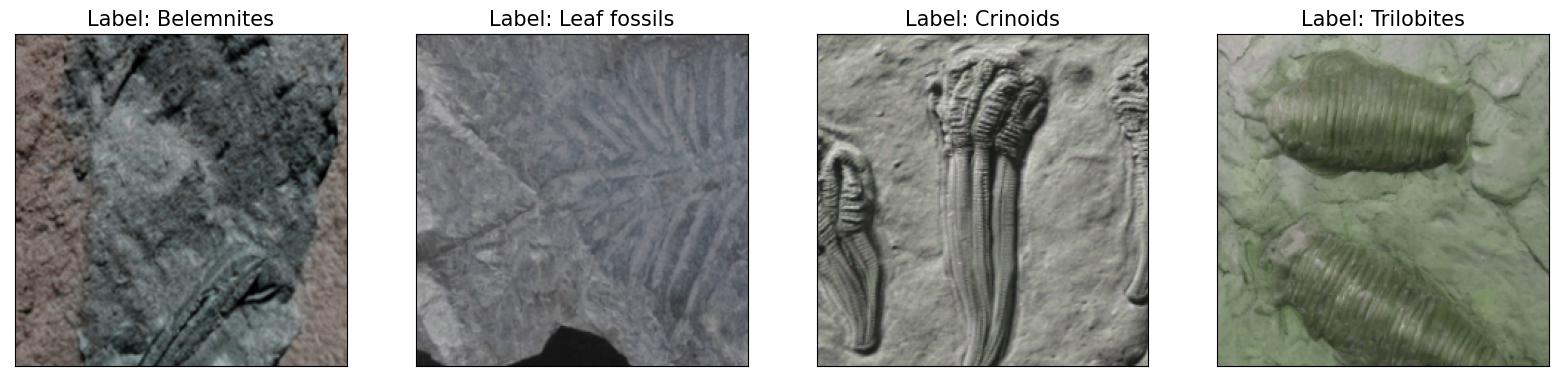

In [14]:
view_image(dataloaders['train'], samples=4)

In [15]:
class MetricMonitor:
    def __init__(self, float_precision=3):
        self.float_precision = float_precision
        self.reset()

    def reset(self):
        self.metrics = defaultdict(lambda: {"val": 0, "count": 0, "avg": 0})

    def update(self, metric_name, val):
        metric = self.metrics[metric_name]

        metric["val"] += val
        metric["count"] += 1
        metric["avg"] = metric["val"] / metric["count"]

    def __str__(self):
        return " | ".join(
            [
                "{metric_name}: {avg:.{float_precision}f}".format(
                    metric_name=metric_name, avg=metric["avg"], float_precision=self.float_precision
                )
                for (metric_name, metric) in self.metrics.items()
            ]
        )

In [16]:
def train(train_loader, model, criterion, optimizer, epoch, params, backbone):
    metric_monitor = MetricMonitor()
    model.train()
    stream = tqdm(train_loader)
    for i, (images, target) in enumerate(stream, start=1):
        images = images.to(params["device"], non_blocking=True)
        target = target.to(params["device"], non_blocking=True)
        if backbone == "inception":
            images = Resize(299)(images)
            output, _ = model(images)
        else:
            output = model(images)
        loss = criterion(output, target)
        metric_monitor.update("Loss", loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        stream.set_description(
            "Epoch: {epoch}. Train.      {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor)
        )
    return model

In [17]:
def validate(val_loader, model, criterion, epoch, params):
    metric_monitor = MetricMonitor()
    model.eval()
    stream = tqdm(val_loader)
    predictions = torch.tensor([])
    targets = torch.tensor([])
    with torch.no_grad():
        for i, (images, target) in enumerate(stream, start=1):
            images = images.to(params["device"], non_blocking=True)
            target = target.to(params["device"], non_blocking=True)
            output = model(images)
            loss = criterion(output, target)
            metric_monitor.update("Loss", loss.item())
            stream.set_description(
                "Epoch: {epoch}. Validation. {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor)
            )
            _, predicted = torch.max(output, 1)
            predictions = torch.cat((predictions, predicted.cpu()),0)
            targets = torch.cat((targets, target.cpu()),0)
    report = classification_report(targets, predictions, target_names=class_names, digits=3, output_dict=True, zero_division=0)
    test_acc = report['accuracy']
    report = classification_report(targets, predictions, target_names=class_names, digits=3, zero_division=0)
    return test_acc, report

In [18]:
def save_model(model, backbone, params):
    best_model_state = copy.deepcopy(model.state_dict())
    name = backbone + params["model_name"]
    torch.save(best_model_state, name)

In [19]:
def train_and_validate(model, train_loader, val_loader, params, backbone):    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(
        (p for p in model.parameters() if p.requires_grad), lr=params["lr"]
    )
    max_score = 0
    max_report = ''
    for epoch in range(1, params["epochs"] + 1):
        model = train(train_loader, model, criterion, optimizer, epoch, params, backbone)
        test_acc, report = validate(val_loader, model, criterion, epoch, params)
        #print(report)
        if test_acc >= max_score:
            save_model(model, backbone, params)
            max_score = test_acc
            max_report = report
    print(report)
    return model

In [20]:
def create_model(backbone, params):
    model = nn.Sequential(nn.Linear(256, num_classes))
    head_name = ""
    if backbone == "resnet":
        model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
        n_inputs = model.fc.in_features
        head_name = "fc"
        model.fc = nn.Sequential(
                              nn.Linear(n_inputs, 256), 
                              nn.ReLU(), 
                              nn.Dropout(0.4),
                              nn.Linear(256, num_classes))
    elif backbone == "vit":
        model = vit_b_16(weights=ViT_B_16_Weights.IMAGENET1K_V1)
        n_inputs = model.heads.head.in_features
        head_name = "head"
        model.heads.head = nn.Sequential(
                              nn.Linear(n_inputs, 256), 
                              nn.ReLU(), 
                              nn.Dropout(0.4),
                              nn.Linear(256, num_classes))
    elif backbone == "vit32":
        model = vit_b_32(weights=ViT_B_32_Weights.IMAGENET1K_V1)
        n_inputs = model.heads.head.in_features
        head_name = "head"
        model.heads.head = nn.Sequential(
                                nn.Linear(n_inputs, 256), 
                                nn.ReLU(), 
                                nn.Dropout(0.4),
                                nn.Linear(256, num_classes))
    elif backbone == "inception":
        model = inception_v3(weights=Inception_V3_Weights.IMAGENET1K_V1)
        n_inputs = model.fc.in_features
        head_name = "fc"
        model.fc = model.fc = nn.Sequential(
                              nn.Linear(n_inputs, 256), 
                              nn.ReLU(), 
                              nn.Dropout(0.4),
                              nn.Linear(256, num_classes))
    return model, head_name

In [21]:
backbones = ["resnet", "vit", "inception", "vit32"]

In [22]:
for backbone in backbones:
    
    print( f"        ------ Model architecture: '{backbone}' ------" )
    model, head_name = create_model(backbone, params)
    for name, param in model.named_parameters():
        if name.startswith(head_name):
            param.requires_grad = True
        else:
            param.requires_grad = False
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Total parameters: {total_params}")
    model = model.to(params["device"])
    model = train_and_validate(model, dataloaders['train'], dataloaders['test'], params, backbone)
    print(" ")
    print(" ")

        ------ Model architecture: 'resnet' ------
Total parameters: 24034118


Epoch: 3. Validation. Loss: 1.445: 100%|████████| 15/15 [00:02<00:00,  6.98it/s]


              precision    recall  f1-score   support

   Ammonites      0.731     0.950     0.826        40
  Belemnites      0.860     0.925     0.892        40
      Corals      0.944     0.850     0.895        40
    Crinoids      0.921     0.875     0.897        40
Leaf fossils      1.000     0.525     0.689        40
  Trilobites      0.780     0.975     0.867        40

    accuracy                          0.850       240
   macro avg      0.873     0.850     0.844       240
weighted avg      0.873     0.850     0.844       240

 
 
        ------ Model architecture: 'vit' ------
Total parameters: 85997062


Epoch: 3. Validation. Loss: 1.474: 100%|████████| 15/15 [00:03<00:00,  4.83it/s]


              precision    recall  f1-score   support

   Ammonites      0.941     0.800     0.865        40
  Belemnites      0.824     0.700     0.757        40
      Corals      0.760     0.950     0.844        40
    Crinoids      0.781     0.625     0.694        40
Leaf fossils      0.750     0.750     0.750        40
  Trilobites      0.800     1.000     0.889        40

    accuracy                          0.804       240
   macro avg      0.809     0.804     0.800       240
weighted avg      0.809     0.804     0.800       240

 
 
        ------ Model architecture: 'inception' ------
Total parameters: 25638350


Epoch: 3. Validation. Loss: 1.660: 100%|████████| 15/15 [00:02<00:00,  6.65it/s]


              precision    recall  f1-score   support

   Ammonites      0.788     0.650     0.712        40
  Belemnites      0.833     0.375     0.517        40
      Corals      0.833     0.125     0.217        40
    Crinoids      0.600     0.525     0.560        40
Leaf fossils      0.462     0.450     0.456        40
  Trilobites      0.312     0.850     0.456        40

    accuracy                          0.496       240
   macro avg      0.638     0.496     0.487       240
weighted avg      0.638     0.496     0.487       240

 
 
        ------ Model architecture: 'vit32' ------
Total parameters: 87653638


Epoch: 3. Validation. Loss: 1.491: 100%|████████| 15/15 [00:02<00:00,  6.96it/s]


              precision    recall  f1-score   support

   Ammonites      1.000     0.850     0.919        40
  Belemnites      0.778     0.875     0.824        40
      Corals      0.833     0.875     0.854        40
    Crinoids      1.000     0.525     0.689        40
Leaf fossils      0.744     0.725     0.734        40
  Trilobites      0.678     1.000     0.808        40

    accuracy                          0.808       240
   macro avg      0.839     0.808     0.804       240
weighted avg      0.839     0.808     0.804       240

 
 
